In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from nelson_siegel_svensson.calibrate import errorfn_ns_ols, betas_ns_ols

# Loading dataset

In [11]:
def read_files(path, filenames):
    """Reads all files and returns a dataframe"""
    return pd.concat((pd.read_csv(path + f, skipinitialspace=True) for f in filenames))

In [12]:
path_opt = "./data/raw_data/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for year in range(2011, 2023) for month in range(1, 13)] + ["spx_eod_2023" + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for month in range(1, 4)]
df = read_files(path_opt, filenames_opt)

In [13]:
# Filter after between 2011-02-11
df = df[df["[QUOTE_DATE]"] >= "2011-02-11"]


len_after_first_read = len(df)

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Date,Maturity,Volume,Average Volume
7913,1297458000,2011-02-11 16:00,2011-02-11,16.0,1329.2,2011-02-11,1297458000,0.0,0.99134,0.00014,...,-0.02500,0.00000,1.32317,0.0,254.2,0.191,2011-02-11,0.0,0.0,161.71
7914,1297458000,2011-02-11 16:00,2011-02-11,16.0,1329.2,2011-02-11,1297458000,0.0,0.99075,0.00023,...,-0.02522,-0.00047,1.19079,0.0,229.2,0.172,2011-02-11,0.0,0.0,161.71
7915,1297458000,2011-02-11 16:00,2011-02-11,16.0,1329.2,2011-02-11,1297458000,0.0,0.99005,0.00028,...,-0.02470,-0.00027,1.05795,0.0,204.2,0.154,2011-02-11,0.0,0.0,161.71
7916,1297458000,2011-02-11 16:00,2011-02-11,16.0,1329.2,2011-02-11,1297458000,0.0,0.98849,0.00030,...,-0.02541,-0.00030,0.92981,10.0,179.2,0.135,2011-02-11,0.0,0.0,161.71
7917,1297458000,2011-02-11 16:00,2011-02-11,16.0,1329.2,2011-02-11,1297458000,0.0,0.98691,0.00047,...,-0.02435,0.00000,0.80122,42.0,154.2,0.116,2011-02-11,0.0,0.0,161.71


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_26298/2127720546.py:25: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


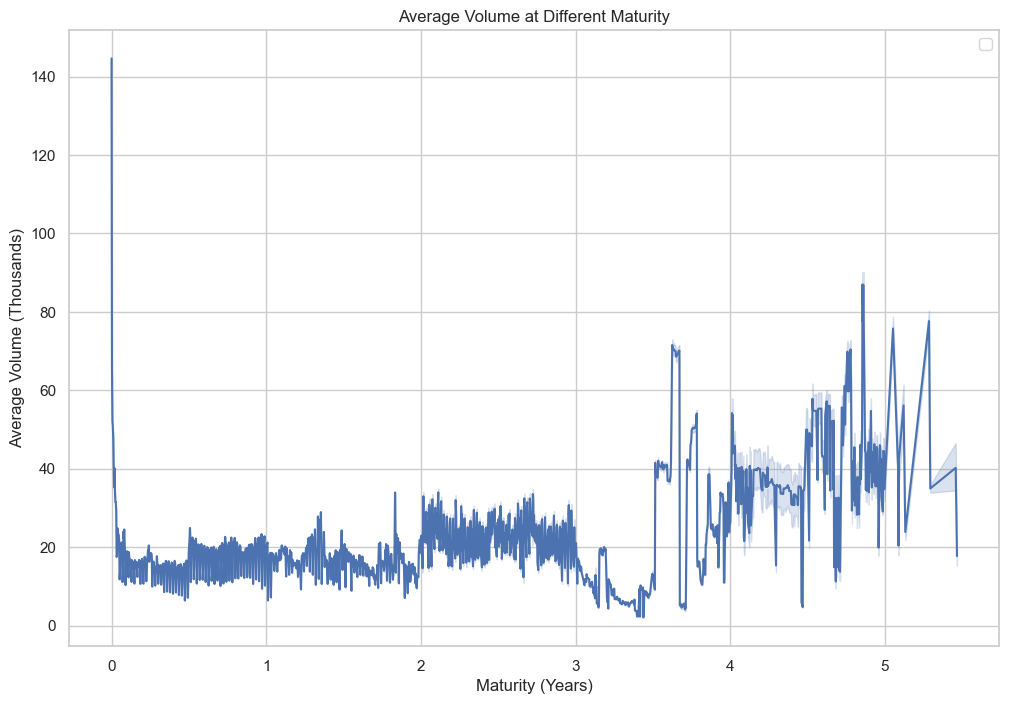

In [14]:
# plot avergae volume at different maturity
df["Date"] = pd.to_datetime(df["[QUOTE_DATE]"])
df["Maturity"] = pd.to_datetime(df["[EXPIRE_DATE]"]) - df["Date"]
df["Maturity"] = df["Maturity"].dt.days
df["Maturity"] = df["Maturity"] / 365
df["Volume"] = df["[C_VOLUME]"]
# Replace nan with 0 for volume
df["Volume"] = df["Volume"].fillna(0)
df["Average Volume"] = df.groupby("Maturity")["Volume"].transform("mean")
df["Average Volume"] = df["Average Volume"]
df["Average Volume"] = df["Average Volume"].round(2)

display(df.head())

# Create plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Add line for average for Maturity > 2 and for Maturity < 2
average_volume_2 = df[df["Maturity"] > 2]["Average Volume"].mean()
average_volume_0_2 = df[df["Maturity"] < 2]["Average Volume"].mean()

# Smooth graph with gaussian filter
from scipy.ndimage.filters import gaussian_filter1d
df["Average Volume"] = gaussian_filter1d(df["Average Volume"], sigma=30)



plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x="Maturity", y="Average Volume")
plt.title("Average Volume at Different Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Average Volume")
plt.legend()
plt.show()


In [15]:
print("Average Volume for Maturity > 2: " + str(average_volume_2))
print("Average Volume for Maturity < 2: " + str(average_volume_0_2))

Average Volume for Maturity > 2: 13.216431941341058
Average Volume for Maturity < 2: 24.144249078743915


/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_26298/4123292133.py:22: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


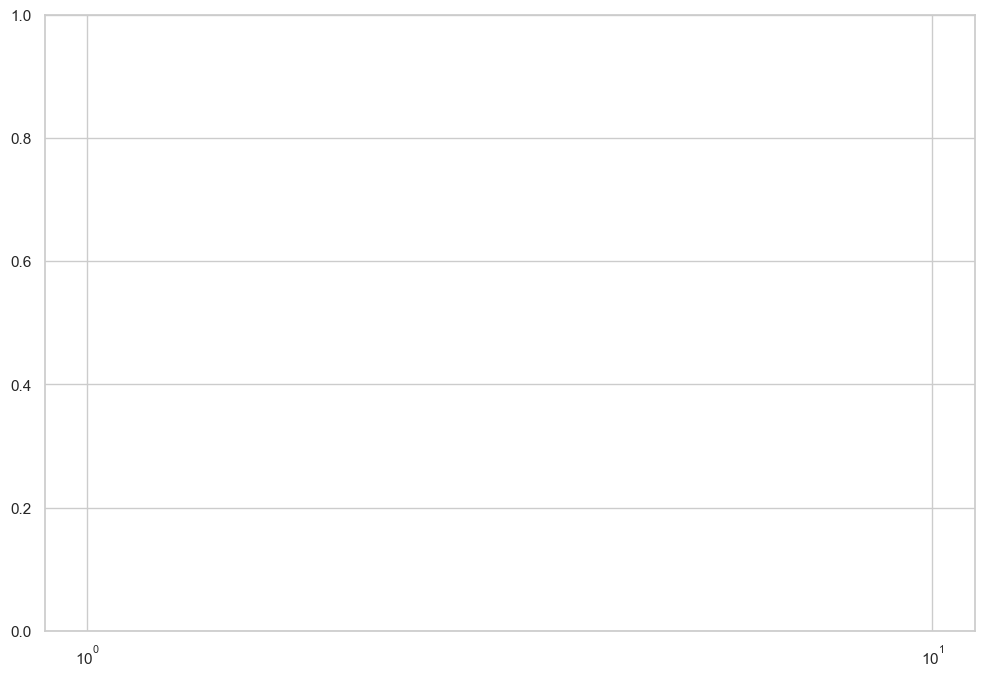

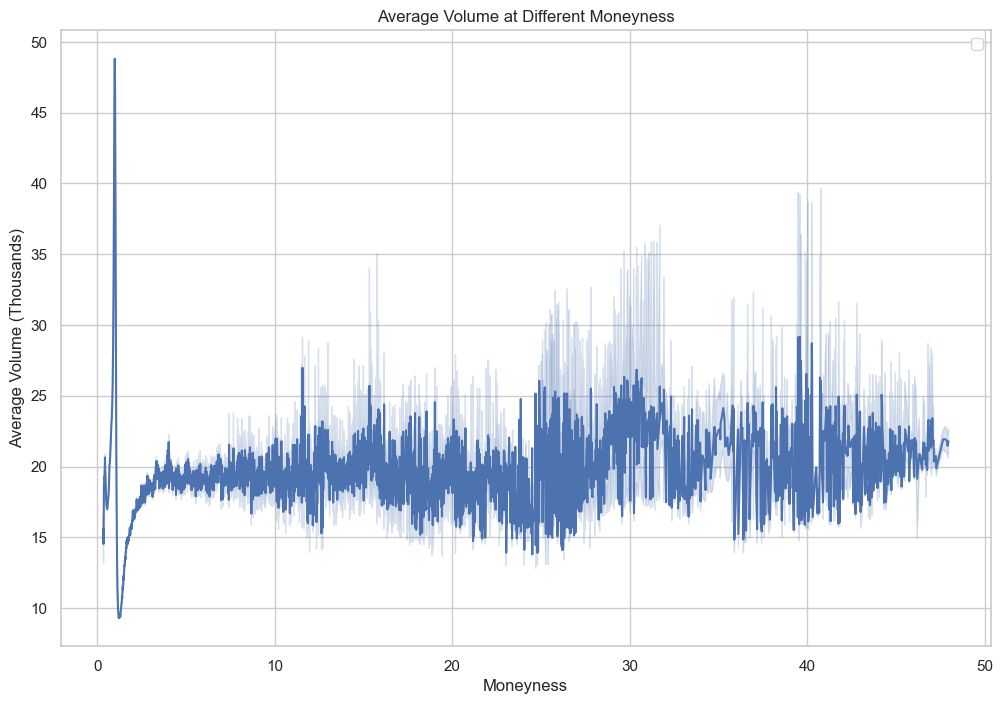

In [16]:
# Add moneyness column
df["Moneyness"] = df["[UNDERLYING_LAST]"] / df["[STRIKE]"]

# Round moneyness into 100 bins
df["Moneyness"] = df["Moneyness"].round(2)

# Make graph like above but for moneyness
df["Average Volume"] = df.groupby("Moneyness")["Volume"].transform("mean")
df["Average Volume"] = df["Average Volume"]
df["Average Volume"] = df["Average Volume"].round(2)


average_volume_2 = df[df["Moneyness"] > 2]["Average Volume"].mean()
average_volume_0_2 = df[df["Moneyness"] < 0.8]["Average Volume"].mean()
average_volume_between = df[(df["Moneyness"] > 0.8) & (df["Moneyness"] < 2)]["Average Volume"].mean()

# Make x-axis logarithmic
plt.figure(figsize=(12, 8))
plt.xscale("log")

# Smooth graph with gaussian filter
from scipy.ndimage.filters import gaussian_filter1d
df["Average Volume"] = gaussian_filter1d(df["Average Volume"], sigma=30)





plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x="Moneyness", y="Average Volume")
plt.title("Average Volume at Different Moneyness")
plt.xlabel("Moneyness")
plt.ylabel("Average Volume (Thousands)")
plt.legend()
plt.show()



In [19]:
print("Average Volume for Moneyness > 2.0: " + str(average_volume_2))
print("Average Volume for Moneyness < 0.8: " + str(average_volume_0_2))
print("Average volume for 0.8-2.0: " + str(average_volume_between))

Average Volume for Moneyness > 2.0: 7.045028240807627
Average Volume for Moneyness < 0.8: 20.921668242903557
Average volume for 0.8-2.0: 25.244905581981204
